In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_feynmannd
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
import dataset_miscnd
import space
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 100
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 200
MAX_STREE_DEPTH  = 8
MAX_STREE_LENGTH = 20
GENERATIONS      = 25
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 20000
LIB_MAXDEPTH  = 3 #5
LIB_MAXLENGTH = 10 #15

BACKPROP_TRIALS = 2

RANDSTATE = 124

In [3]:
randstate.setstate(RANDSTATE)

S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc3d.Resistance3()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.RocketFuelFlow()
#S = dataset_physics.AircraftLift()
#S = dataset_misc2d.Pagie1()
#S = dataset_miscnd.WavePower()
#S = dataset_feynmannd.FeynmanIICh6Eq15a()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
import profiling
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

const_prob = 0.0 if S.knowledge.has_symmvars() else 0.5
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, const_prob=const_prob)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

mesh           = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, mesh)
data_evaluator = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, data_evaluator, know_pressure=1.0)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)
#corrector.backprop_trials = BACKPROP_TRIALS

settings = gp.GPSettings(
      POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
      creator=solutionCreator,
      evaluator=evaluator,
      selector=selector,
      crossover=crossover,
      mutator=multiMutator,
      corrector=corrector,
      mutrate=MUTATION_RATE,
      elitism=ELITISM,
      knowledge=S.knowledge)
symb_regressor = gp.GP(settings)
#symb_regressor = gp.MOGP(settings)

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

  0%|          | 0/24 [00:00<?, ?it/s]

         6977739 function calls (6696849 primitive calls) in 12.611 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.578    0.578   12.611   12.611 clibrary.py:9(__init__)
        1    0.647    0.647   10.387   10.387 library.py:128(__init__)
        2    0.293    0.146    7.075    3.538 creator.py:124(create_population)
    70979    0.888    0.000    5.199    0.000 creator.py:63(ptc2)
   193313    0.764    0.000    2.245    0.000 creator.py:43(createRandomNonTerminal)
   147630    0.331    0.000    1.500    0.000 creator.py:38(createRandomTerminal)
   417397    1.026    0.000    1.224    0.000 syntax_tree.py:67(__init__)
126255/76993    0.233    0.000    1.152    0.000 binop.py:62(simplify)
158010/99152    0.195    0.000    1.111    0.000 unaop.py:53(simplify)
   144871    0.397    0.000    0.872    0.000 const.py:7(__init__)
70135/44456    0.125    0.000    0.744    0.000 binop.py:40(at)
52876/30913    0.1

In [5]:
test_data_evaluator = gp_evaluator.R2Evaluator(S_test)
best_stree.clear_output()
print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
print(f"Test R2: {test_data_evaluator.evaluate(best_stree).value}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")


--- Best syntax tree ---
(x0 * (-1.98 / ((sqrt((square(x0) / 0.13)) * square(((x0 + x0) * 0.90))) - -0.17)))
fea: 1.0
R²: 0.9985317592461977
Max depth: 7
Length: 18
Test R2: 0.9977465683600454


In [6]:
best_stree.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
print(S.evaluate_extra(best_stree))
print(know_evaluator.evaluate(best_stree))

{'mse': 0.009780261866698269, 'rmse': 0.09889520648999257, 'r2': 0.9753365212656956}
(184, 0)


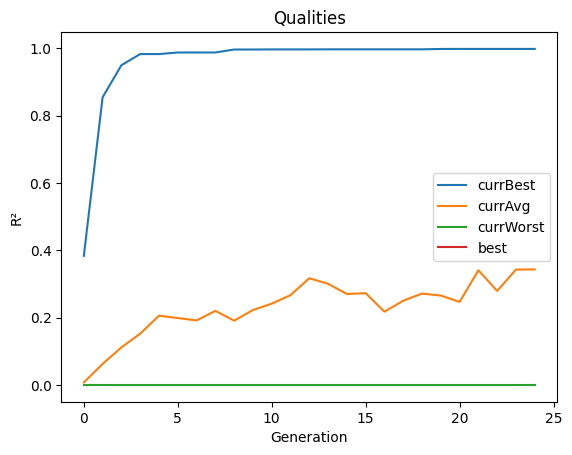

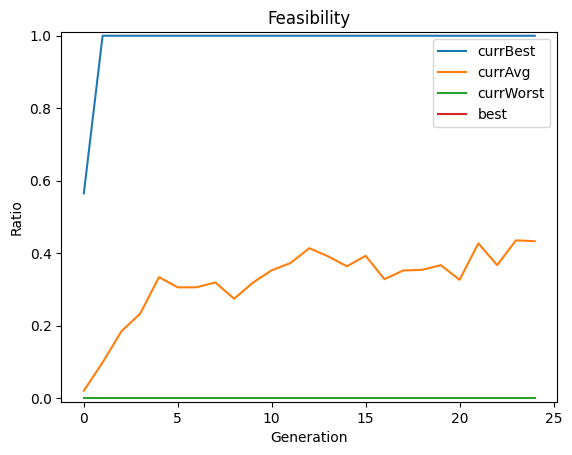

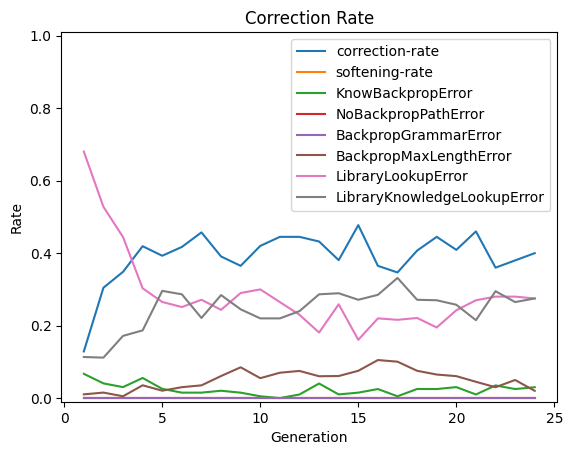

In [7]:
symb_regressor.stats.plot()

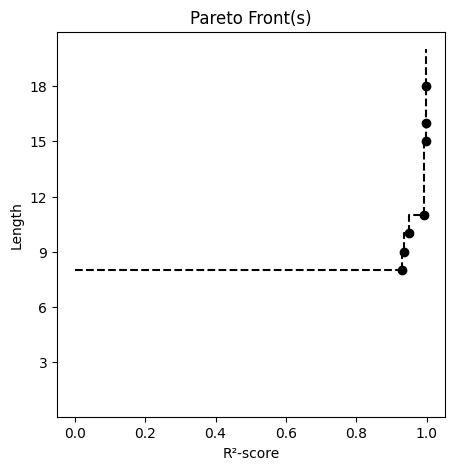

Feasibility Ratio: 1.0
Extent of Convergence: 0.6197228363797727


,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,(x0 * (-1.98 / ((sqrt((square(x0) / 0.13)) * s...,0,0.099853,0.998532,18,"(sqrt, +, /, square, *)",1,inf
1,1,(x0 * (-0.64 / (0.07 + square(x0)))),0,0.557357,0.928928,8,"(/, square, *)",2,inf
2,2,((x0 / (-0.79 + exp((square(x0) / 0.26)))) * -...,0,0.446686,0.992635,11,"(/, exp, square)",1,1.178261
3,3,(x0 * (-1.98 / (square((x0 + x0)) - -0.17))),0,0.475060,0.950121,10,"(/, square, +, *)",1,1.044171
4,4,(x0 * (-1.98 / (((0.71 + square((x0 / -0.22)))...,0,0.249333,0.997330,15,"(/, square, *)",2,0.583369
5,5,(x0 * (0.76 / (0.91 - exp(square(x0))))),0,0.513633,0.933877,9,"(/, exp, square, *)",1,0.504478
6,6,((-1.98 / ((square((x0 / 0.21)) * sqrt((0.17 *...,0,0.199688,0.998438,16,"(/, square, sqrt, *)",1,0.317261


In [8]:
pd_data = []
front_tracker, fea_ratio = symb_regressor.fea_front_tracker.get_head(0)

for frontidx in range(len(front_tracker.front)):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

data_lu = (0.0,1.0)
length_lu = (1,MAX_STREE_LENGTH)

front_tracker.plot(data_lu, length_lu, [0])
print(f"Feasibility Ratio: {fea_ratio}")
print(f"Extent of Convergence: {front_tracker.compute_extend_of_convergence(data_lu, length_lu)}")
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)